<a href="https://colab.research.google.com/github/nomadicsenseis/VisionTransformer/blob/main/VisionTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Vision Transformer

As I commented on my repo https://github.com/nomadicsenseis/annoted-transformer, since their first appearenace in 2017 Transformers have taken oer the NLP world. But they were not done yet. Afer some attempts of deploying them in tandem with CNNs, Google (https://arxiv.org/abs/2010.11929) finally published a paper where they implemented them directly on the task of Computer Vision. In this work I aim to recreate what they did on that paper.

As for the actual frameworks, I will go for PyTorch and AWS, more specifically I will train on a Trainnium instance using the Hugging Face's base image and the Neuron SDK; and for TensorFlow Extended (the distribute library) to train the model on a TPU in the GCP. 

However, since the purpose of this notebook is merely educational, I will do the trainning using Pytorch and Colab first. In further implementations I will go through trainning in different frameworks.

##Architecture


Basically, a VIT is an Encoder Transformer connected to a multilayer perceptron (1 hidden layer during trainning, and linear layer during fine tuning) that outputs a label probability. As in NLP, the transformer must input some context-free representation of some kind of token, and by the end of the trainning, it should output a context representation of each of those tokens. Now, what they did in this paper is creating a series of patches out of the original images, and they used them as tokens for the encoder. There are multiple ways of creating these patches, they mentioned that it is even possible to get them as the outputs of the hidden layers of some CNNs. What is is important though, is that the number of them must be relativeley low, in orther to keep the number of computed attentions reasonable. In particular, they just divided the image into 16 x 16 patches, and then they projected each patch to the a D-length vector through a learnable linear layer. So the initial "positional+context free embedding" is learned (in contrast with the original Attention is all you need where they were hard coded).

But, how do they handle the trainning? In a NLP fashion, what we would do to train an encoder (like BERT) is hidding some token representation withing the sequence and make the transformer learn how to make proper representations of the rest of the tokens in order to predict it. But that is done because there is vocab that we can aim to and a loss funtion based on that vocab. How about image patches? In principle, there is no vocab of image patches, in fact they can be anything. What they do is basically introduce an extra token to the transformer with a representation of the label assigned to that image. This token will act as the hidden token that needs to be predicted, with labels acting as the vocab in an NLP-transformer. It is worth noticing though that this patch s always added in the position 0, so there is no postional embedding to learn (it doesnt belong to any position in the image).

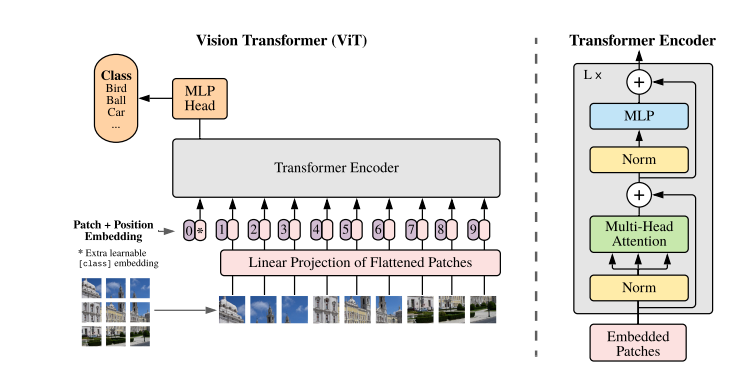

In [40]:
from IPython.display import Image
Image(filename='/content/ViTransformer.png', width=600, height=350)

###PyTorch

In [41]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [42]:
#Imports for Harvard PyTorch implementation
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

####Patch embbeding

In [43]:
class PatchEmbedding(nn.Module):
  """This module is going to turn a 2D imagae into a 1D sequence vector that can be fed into the Encoder. It is the equivalent as the free-of-context embbeding
     used to train the NLP transformers.
     
     Args: in_channels (int) Number of color channels for the input image. Default to 3.
           patch_size (int) Size of the patches to convert the input image into. They are the equivalent to tokens. Defaulst to 16.
           patch_embedding (int) Size of the embedding to turn the image into. Defaults to 768.
  """
  def __init__(self, 
               in_channels:int=3,
               patch_size:int=16,
               size_embedding:int=768):
      super().__init__()
      self.patch_size=patch_size
      
      self.patcher=nn.Conv2d(in_channels=in_channels,
                             out_channels=size_embedding,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0
                             )
      # 4. Create a layer to flatten the patch feature maps into a single dimension
      self.flatter = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                end_dim=3
                               )
      
  def forward(self, x):
      # Create assertion to check that inputs are the correct shape
      image_resolution = x.shape[-1]
      assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        
      # Perform the forward pass
      x_patched = self.patcher(x)
      x_flattened = self.flatter(x_patched) 
      # Make sure the output shape has the right order 
      return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]


   

####Transformer Enconder

In [44]:
class NormLayer(nn.Module):
  def __init__(self,char,eps=1e-6):
    super(NormLayer,self).__init__()
    self.a=nn.Parameter(torch.ones(char))
    self.b=nn.Parameter(torch.zeros(char))
    self.eps=eps

  def forward(self,x):
    mean=x.mean(-1,keepdim=True)
    std=x.std(-1,keepdim=True)
    return self.a*(x-mean)/(std+self.eps)+self.b

In [45]:
class ResidualConnection(nn.Module):
  """
  Una conexión residual seguida de una capa de normalización. 
  """

  def __init__(self, tamaño, dropout):
    super(ResidualConnection,self).__init__()
    self.norm=NormLayer(tamaño)
    self.dropout=nn.Dropout(dropout)

  def forward(self, x, subLayer):
    "Aplica conexion residual a cualquier sub capa con el mismo tamaño."
    return x + self.dropout(subLayer(self.norm(x)))

In [46]:
def attention(query, key, value, mask= None, dropout=None):
  d_q=query.size(-1)
  scores=torch.matmul(query,key.transpose(-2,-1)) / np.sqrt(d_q)
  if mask is not None:
    scores=scores.masked_fill(mask==0,-1e9)
  p_attn=F.softmax(scores,dim=-1)
  if dropout is not None:
    p_attn=dropout(p_attn)
  return torch.matmul(p_attn,value),p_attn


  

Say you want to apply attention from every token in the primary sequence to every token in a context sequence. Each of those tokens will have a d_model size representaiton of the token. So, to apply the attention mechanism I first create 4 nn.Linear(d_model,d_model) sized matrixes, that project the d_model original token_representations to another d_model sized vector. In the case of the query tokens, this vector will be a "d_model" sized "query", that will be split in h vector of dimension d_q (h being the number of heads). The same will be done with each of the token in the context sequence, only this time they will be projected and split into the key and value vectors. To prevent overfitting and better the model's efficiency, we will set this vectors to have d_q dimension. When attention is applied, each of the h d_q query vectors pays attention to each of the key and value vectors withing the respective head. Then, the resultant h vectors are concatenated, making a d_model sized vector and projected back to go on trhough the transformer model.

In [47]:
class MultiHeadedattention(nn.Module):
  def __init__(self,h,d_model,dropout=0.1):
    super(MultiHeadedattention,self).__init__()
    assert d_model % h ==0 
    self.d_k=d_model//h
    self.h=h
    self.linears=clones(nn.Linear(d_model,d_model),4)
    self.attn=None
    self.dropout=nn.Dropout(p=dropout)

  def forward(self, primary, context, mask=None):
    if mask is not None:
      mask=mask.unsqueeze(1)
    nbatches=primary.size(0)
  # 1) hacer todas las proyecciones lineales en lotes desde d_model => h x d_k
    query,key,value= [l(x).view(nbatches,-1,self.h, self.d_k).transpose(1,2) for l,x in zip(self.linears,(primary,context,context))]
  # 2) Aplicar el mecanismod e atención en todos los vectores proyectdos por lotes.
    x, self.attn=attention(query,key,value,mask=mask,dropout=self.dropout)
  # 3) Concatenar utilizando un view y aplicar la capa lineal final.
    x=x.transpose(1,2).contiguous().view(nbatches,-1,self.h*self.d_k)

    return self.linears[-1](x)

  


In [48]:
class PositionwiseFeedForward(nn.Module):
  def __init__(self,d_model,d_ff,dropout=0.1):
    super(PositionwiseFeedForward,self).__init__()
    self.w_1=nn.Linear(d_model,d_ff)
    self.w_2=nn.Linear(d_ff,d_model)
    self.dropout=nn.Dropout(dropout)

  def forward(self,x):
    return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [49]:
class EncoderLayer(nn.Module):
  def __init__(self,tamaño,self_attn,PFF,dropout):
    super(EncoderLayer,self).__init__()
    self.self_attn=self_attn
    self.PFF=PFF
    self.subcapa=clones(ResidualConnection(tamaño,dropout),2)
    self.tamaño=tamaño

  def forward(self, x,mask):
    x=self.subcapa[0](x,lambda x: self.self_attn(x,x,mask))
    return self.subcapa[1](x, self.PFF)



In [50]:
def clones(module,N):
  """
  Produce N capas idénticas.
  """
  return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [51]:
class Encoder(nn.Module):
  """
  El núcleo del encoder es un stack de N capas
  """
  def __init__(self,capa,N):
    super(Encoder, self).__init__()
    self.capas = clones(capa,N)
    self.norm = NormLayer(capa.tamaño)

  def forward(self,x,mask):
    """
    Pasa el input (y máscara) a traves de cada capa en respuesta.
    """
    for capa in self.capas:
      x=capa(x,mask)
    return self.norm(x)

In [52]:
encoder=Encoder(EncoderLayer(768, copy.deepcopy(MultiHeadedattention(4, 768)), 
                                                    copy.deepcopy(PositionwiseFeedForward(768, 3012, 0.1)), 
                                                    0.005), 
                                       4)

In [53]:
encoder

Encoder(
  (capas): ModuleList(
    (0-3): 4 x EncoderLayer(
      (self_attn): MultiHeadedattention(
        (linears): ModuleList(
          (0-3): 4 x Linear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (PFF): PositionwiseFeedForward(
        (w_1): Linear(in_features=768, out_features=3012, bias=True)
        (w_2): Linear(in_features=3012, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (subcapa): ModuleList(
        (0-1): 2 x ResidualConnection(
          (norm): NormLayer()
          (dropout): Dropout(p=0.005, inplace=False)
        )
      )
    )
  )
  (norm): NormLayer()
)

####ViT

In [54]:

class ViT(nn.Module): 
  def __init__(self,
               img_size:int=224, # Training resolution from Table 3 in ViT paper
               in_channels:int=3, # Number of channels in input image
               patch_size:int=16, # Patch size
               num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
               embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
               mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
               num_heads:int=12, # Heads from Table 1 for ViT-Base
               attn_dropout:float=0, # Dropout for attention projection
               mlp_dropout:float=0.1, # Dropout for dense/MLP layers 
               embedding_dropout:float=0.1, # Dropout for patch and position embeddings
               num_classes:int=1000):# Default for ImageNet but can customize this
    super().__init__()

    # Assert image size is divisible by patch size 
    assert img_size % patch_size == 0, "Image size must be divisble by patch size."

    # 1. Create patch embedding
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          size_embedding=embedding_dim)

    # 2. Create class token
    self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                    requires_grad=True)

    # 3. Create positional embedding
    self.num_patches = (img_size * img_size) // patch_size**2 # N = HW/P^2
    self.positional_embedding = nn.Parameter(torch.randn(1, self.num_patches+1, embedding_dim))

    # 4. Create patch + position embedding dropout 
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # 5. Create stack Transformer Encoder layers (stacked single layers)
    self.transformer_encoder = Encoder(EncoderLayer(embedding_dim, copy.deepcopy(MultiHeadedattention(num_heads, embedding_dim)), 
                                                    copy.deepcopy(PositionwiseFeedForward(embedding_dim, mlp_size, mlp_dropout)), 
                                                    attn_dropout), 
                                       num_transformer_layers) 

    # 7. Create MLP head
    self.mlp_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    # Get some dimensions from x
    batch_size = x.shape[0]

    # Create the patch embedding
    x = self.patch_embedding(x)
    # print(x.shape)

    # First, expand the class token across the batch size
    class_token = self.class_token.expand(batch_size, -1, -1) # "-1" means infer the dimension

    # Prepend the class token to the patch embedding
    x = torch.cat((class_token, x), dim=1)
    # print(x.shape)

    # Add the positional embedding to patch embedding with class token
    x = self.positional_embedding + x
    # print(x.shape)

    # Dropout on patch + positional embedding
    x = self.embedding_dropout(x)

    # Pass embedding through Transformer Encoder stack
    x = self.transformer_encoder(x, mask=None)

    # Pass 0th index of x through MLP head
    x = self.mlp_head(x[:, 0])

    return x

In [55]:
vit=ViT()

###Trainning on Colab

In [56]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

####Loading Dataset

In [57]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


####Dataloaders

In [58]:
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [59]:
NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [60]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [61]:
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [62]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f5618881f00>,
 ['pizza', 'steak', 'sushi'])

####Visualize a single image

In [63]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

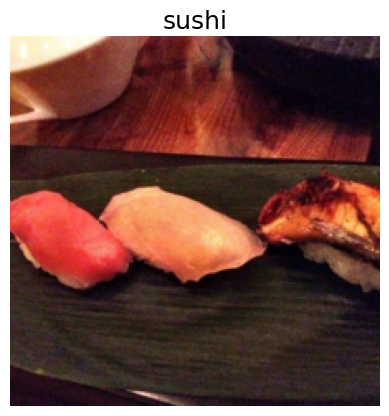

In [64]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

####Try architecture on single image

In [65]:
# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       size_embedding=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


In [66]:
# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[ 0.7852, -0.0487, -0.7031]], grad_fn=<AddmmBackward0>)

In [67]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [68]:
import torchinfo
from torchinfo import summary

# # Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit, 
         input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
         # col_names=["input_size"], # uncomment for smaller output
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"]
         )

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                               [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                      [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                 [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatter)                                [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                           [32, 197, 768]       [32, 197, 768]       --                   --
├─Encoder (transformer_encoder)                         [32, 197, 768]       [32, 197, 768]       --                   True
│    └─ModuleList (capas)                               --                   --                   --                   True
│    │ 

####Create a trainning engine.

In [69]:
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval() 

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch 
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]} 
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

####Train the model

"Training & Fine-tuning. We train all models, including ResNets, using Adam (Kingma & Ba, 2015 ) with 
β
1
=
0.9
,
β
2
=
0.999
, a batch size of 4096 and apply a high weight decay of 
0.1
, which we found to be useful for transfer of all models (Appendix D.1 shows that, in contrast to common practices, Adam works slightly better than SGD for ResNets in our setting)." 

In [36]:
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
optimizer = torch.optim.Adam(params=vit.parameters(), 
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Train the model and save the training results to a dictionary
results = train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.9154 | train_acc: 0.3047 | test_loss: 3.6929 | test_acc: 0.2775
Epoch: 2 | train_loss: 1.9156 | train_acc: 0.3125 | test_loss: 1.4061 | test_acc: 0.2178
Epoch: 3 | train_loss: 1.2005 | train_acc: 0.2852 | test_loss: 1.8422 | test_acc: 0.3826
Epoch: 4 | train_loss: 1.2146 | train_acc: 0.3906 | test_loss: 1.3705 | test_acc: 0.3428
Epoch: 5 | train_loss: 1.2171 | train_acc: 0.2734 | test_loss: 1.1303 | test_acc: 0.3400
Epoch: 6 | train_loss: 1.1433 | train_acc: 0.2734 | test_loss: 1.2013 | test_acc: 0.3400
Epoch: 7 | train_loss: 1.1508 | train_acc: 0.2812 | test_loss: 1.1278 | test_acc: 0.4025
Epoch: 8 | train_loss: 1.2340 | train_acc: 0.2852 | test_loss: 1.1106 | test_acc: 0.3002
Epoch: 9 | train_loss: 1.1173 | train_acc: 0.3945 | test_loss: 1.2474 | test_acc: 0.2576
Epoch: 10 | train_loss: 1.2072 | train_acc: 0.2891 | test_loss: 1.1146 | test_acc: 0.2178


Alright! The transformer is working. Obviusly the resutls are not great, after all, the trainning was done in a relatively small dataset using a basic trainning scheme. ViT transformers achieved some Sota results but with huge datasets and far more complicated trainning scheme. But the good news is the architecture is correct!

###Transfer learning

Just like working with CNNs, the most common way of applying ViTs in real world scenarios is applying an already pretrained model and altering the last layer to the specific classfication task.  

####Why using a pretrainned model?

"Finally, the ViT-L/16 model pre-trained on the public ImageNet-21k dataset performs well on most datasets too, while taking fewer resources to pre-train: it could be trained using a standard cloud TPUv3 with 8 cores in approximately 30 days."

As of July 2022, the price for renting a TPUv3 (Tensor Processing Unit version 3) with 8 cores on Google Cloud is $8 USD per hour.

To rent one for 30 straight days would cost $5,760 USD. 

This cost alone may be a reason to use an already pretrained model. But in our case, where our metrics are so weak and our dataset so small, we may also exprience the benefits of transffer learning in the quality of our results.

####Getting the model

There are a couple of pretrained ViT models out there, for now, Ill stick to one available at torchvision.

In [37]:
# The following requires torch v0.12+ and torchvision v0.13+
import torch
import torchvision
print(torch.__version__) 
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


In [38]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [70]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
#pretrained_vit # uncomment for model output 

####Train the tranfered model.

I already have the DataLoaders and just like with the original trainning, I will use Adam optimizer with a learning rate of 1e-3 and the Cross Entropy as the loss function.

In [72]:

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8771 | train_acc: 0.6094 | test_loss: 0.6664 | test_acc: 0.8049
Epoch: 2 | train_loss: 0.4568 | train_acc: 0.8906 | test_loss: 0.4173 | test_acc: 0.8466
Epoch: 3 | train_loss: 0.3752 | train_acc: 0.9453 | test_loss: 0.2771 | test_acc: 0.9167
Epoch: 4 | train_loss: 0.2484 | train_acc: 0.9336 | test_loss: 0.3114 | test_acc: 0.9062
Epoch: 5 | train_loss: 0.2537 | train_acc: 0.9492 | test_loss: 0.2823 | test_acc: 0.8873
Epoch: 6 | train_loss: 0.1924 | train_acc: 0.9531 | test_loss: 0.2541 | test_acc: 0.9072
Epoch: 7 | train_loss: 0.1731 | train_acc: 0.9492 | test_loss: 0.2351 | test_acc: 0.9072
Epoch: 8 | train_loss: 0.1561 | train_acc: 0.9688 | test_loss: 0.2042 | test_acc: 0.9271
Epoch: 9 | train_loss: 0.1405 | train_acc: 0.9609 | test_loss: 0.1979 | test_acc: 0.9271
Epoch: 10 | train_loss: 0.1286 | train_acc: 0.9609 | test_loss: 0.2170 | test_acc: 0.9072


Well, that is much better than the tranformer I trained in the first section! Great!

###TensorFlow

## Trainning

###AWS

###Google CLoud